In [1]:
! pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.0 MB/s eta 0:00:0000:0100:010m


In [1]:
import pandas as pd
import numpy as np
import proj_acquire
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoLars, TweedieRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier



import warnings
warnings.filterwarnings("ignore")




In [2]:
df = proj_acquire.prep_maint()

In [3]:
df.head()

,air_temp,process_temp,rpm,torque,tool_wear,machine_failure,failure_type,H,L,M
0,298.1,308.6,1551,42.8,0,0,No Failure,0,0,1
1,298.2,308.7,1408,46.3,3,0,No Failure,0,1,0
2,298.1,308.5,1498,49.4,5,0,No Failure,0,1,0
3,298.2,308.6,1433,39.5,7,0,No Failure,0,1,0
4,298.2,308.7,1408,40.0,9,0,No Failure,0,1,0


In [4]:
  #Rename Cols to be more friendly
df.rename(columns = {'Air temperature [K]':'air_temp', 'Process temperature [K]':'process_temp','Rotational speed [rpm]':'rpm', 'Torque [Nm]':'torque', 'Tool wear [min]': 'tool_wear', 'Target':  'machine_failure', 'Failure Type':  'failure_type' }, inplace = True)

# Create dummy variables for type
dummy_df = pd.get_dummies(df['Type'])

#Concat dummy df to the regular df
df = pd.concat([df, dummy_df], axis=1)
    
# Dropping unnecassary columns
df = df.drop(columns=['UDI', 'Product ID', 'Type'])



In [5]:
df.head()

,air_temp,process_temp,rpm,torque,tool_wear,machine_failure,failure_type,H,L,M
0,298.1,308.6,1551,42.8,0,0,No Failure,0,0,1
1,298.2,308.7,1408,46.3,3,0,No Failure,0,1,0
2,298.1,308.5,1498,49.4,5,0,No Failure,0,1,0
3,298.2,308.6,1433,39.5,7,0,No Failure,0,1,0
4,298.2,308.7,1408,40.0,9,0,No Failure,0,1,0


In [6]:
# Splitting the data set via train validate test
def split_maint(df):

    # split the data
    train_validate, test = train_test_split(df, test_size=.2, 
                                            random_state=123, 
                                            stratify=df.failure_type)
    train, validate = train_test_split(train_validate, test_size=.2, 
                                       random_state=123, 
                                       stratify=train_validate.failure_type)
    return train, validate, test

In [7]:
train, test, validate = split_maint(df)

In [8]:
train.shape

(6400, 10)

In [9]:
train.failure_type.value_counts()

No Failure                  6178
Heat Dissipation Failure      72
Power Failure                 61
Overstrain Failure            49
Tool Wear Failure             29
Random Failures               11
Name: failure_type, dtype: int64

<AxesSubplot:>

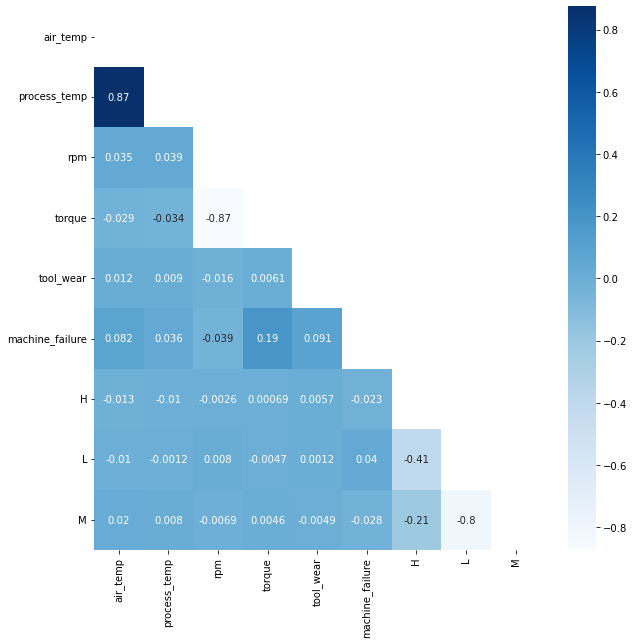

In [10]:
# making a correlation table using spearman becuase data is not normally distributed
correlation_table = train.corr()

# Declaring a size for the heatmap and making heatmap to see the correlations between all variables in the dataset
plt.figure(figsize= (10,10))
sns.heatmap(correlation_table, cmap='Blues', annot = True, mask = np.triu(correlation_table))

* Process temp and air temp are highly correlated 
* RPM and Torque are also highly correlated
* I will attempt to make a ratio from them to see how it compares to dropping a variable to do this I will make 

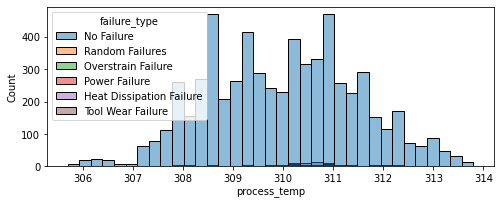

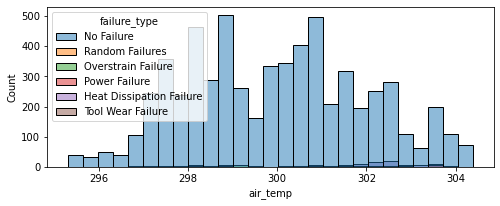

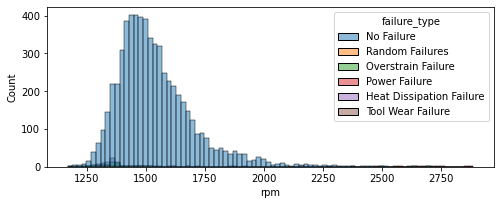

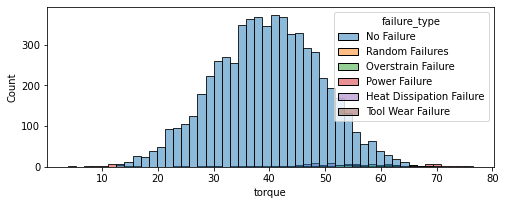

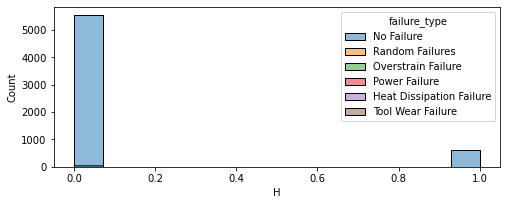

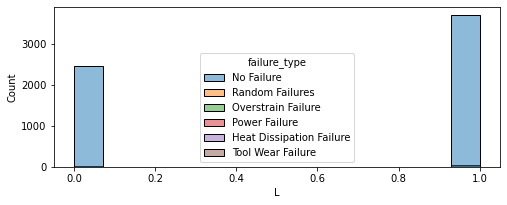

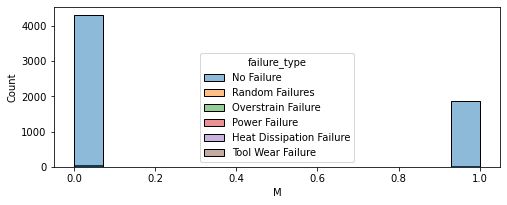

In [11]:
cols= ['process_temp', 'air_temp', 'rpm', 'torque', 'H', 'L', 'M']
m=1
for col in cols:
  plt.figure(figsize=(8,10))
  plt.subplot(3,1,m)
  sns.histplot(data= train, x = col, hue=train.failure_type)
  plt.show()

The features are normally distributed
Accounting for the different types of failures is hard to see because the data is very imbalanced 


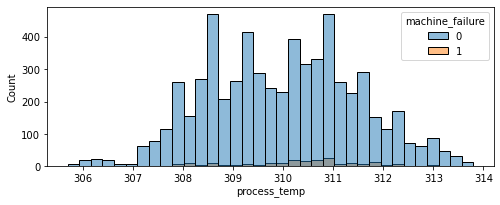

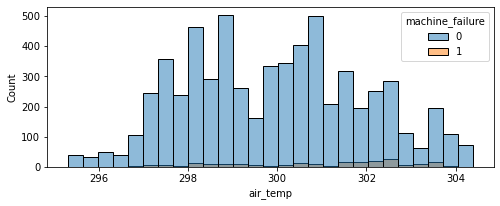

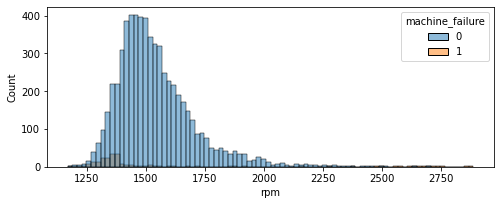

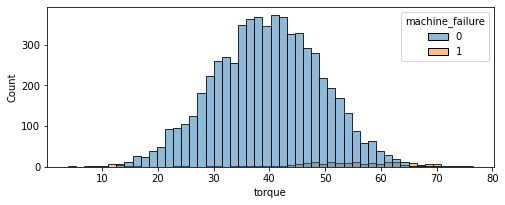

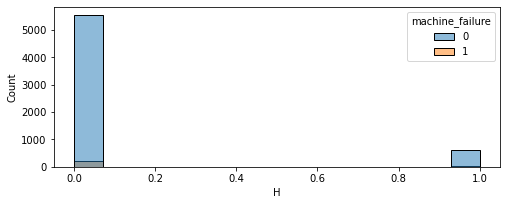

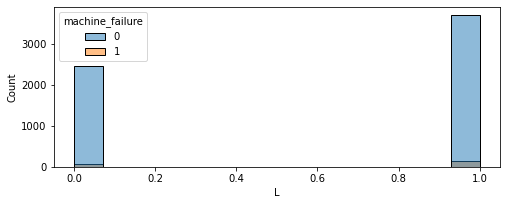

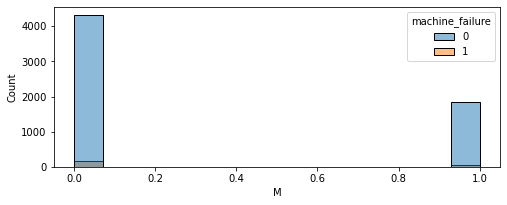

In [12]:
cols= ['process_temp', 'air_temp', 'rpm', 'torque', 'H', 'L', 'M']
m=1
for col in cols:
  plt.figure(figsize=(8,10))
  plt.subplot(3,1,m)
  sns.histplot(data= train, x = col, hue=train.machine_failure)
  plt.show()

This was to vizualize all failures against the features 
* Processing temp fails the most around 310-312 degrees
* Air temp failure is more spread out and the most range from 298 - 303
* The bulk of failure from RPMS is in the lower range < 1500 and comes back at > 2250
* Torque sees more failures when > 50
* L type is most common and has most failures
* M is second most common 
* H is least common with undetectable visual failures.

In [11]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
air_temp,6400.0,299.987281,1.995187,295.3,298.3,300.1,301.5,304.4
process_temp,6400.0,309.996266,1.486978,305.7,308.8,310.0,311.0,313.8
rpm,6400.0,1538.105781,178.083561,1168.0,1424.0,1504.0,1610.0,2886.0
torque,6400.0,40.010219,9.928431,3.8,33.2,40.0,46.8,76.6
tool_wear,6400.0,108.430469,63.557244,0.0,54.0,108.0,163.0,253.0
machine_failure,6400.0,0.033438,0.179790,0.0,0.0,0.0,0.0,1.0
H,6400.0,0.098281,0.297718,0.0,0.0,0.0,0.0,1.0
L,6400.0,0.604375,0.489023,0.0,0.0,1.0,1.0,1.0
M,6400.0,0.297344,0.457125,0.0,0.0,0.0,1.0,1.0


process temp is on average higher than air temp so I will divide process by air 
rpm is higher than torque on average and will divide rpm by torque

In [12]:
train_engineer = train.copy()

In [13]:
train_drop = train.copy()

In [14]:
validate_engineer = validate.copy()

In [15]:
train_engineer.head()

,air_temp,process_temp,rpm,torque,tool_wear,machine_failure,failure_type,H,L,M
5884,301.3,311.1,1438,43.0,137,0,No Failure,0,0,1
6928,301.1,311.7,1816,24.5,7,0,No Failure,0,1,0
4514,302.4,310.3,1479,36.2,115,0,No Failure,0,1,0
9532,299.2,310.5,1384,48.7,93,0,No Failure,0,1,0
6607,301.5,310.5,1556,39.1,48,0,No Failure,0,1,0


In [16]:
train_engineer['temp_ratio'] = train_engineer.process_temp / train_engineer.air_temp

train_engineer['rpm_ratio'] = train_engineer.rpm / train_engineer.torque

In [17]:
validate_engineer['temp_ratio'] = validate_engineer.process_temp / validate_engineer.air_temp

validate_engineer['rpm_ratio'] = validate_engineer.rpm / validate_engineer.torque

Text(0.5, 1.0, 'RPM speed bins against failure average')

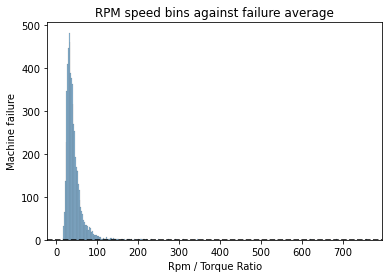

In [18]:
# Plotting out internet service type against churn with overal churn mean as the black line
sns.histplot(x=train_engineer.rpm_ratio, data=train, alpha=.5)
plt.axhline(train_engineer.machine_failure.mean(), ls = '--', color = 'black')
plt.xlabel('Rpm / Torque Ratio')
plt.ylabel('Machine failure')
plt.title('RPM speed bins against failure average')

In [19]:
t, p = stats.ttest_ind(train_engineer.rpm_ratio,train_engineer.machine_failure, equal_var=False)
    
t, p / 2
a=0.05
if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

We reject the null hypothesis and this variable is statistically significant


Text(0.5, 1.0, 'RPM speed bins against failure average')

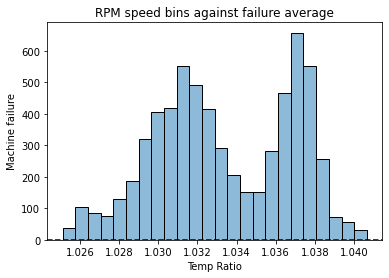

In [20]:
# Plotting out internet service type against churn with overal churn mean as the black line
sns.histplot(x=train_engineer.temp_ratio, data=train, alpha=.5)
plt.axhline(train_engineer.machine_failure.mean(), ls = '--', color = 'black')
plt.xlabel('Temp Ratio')
plt.ylabel('Machine failure')
plt.title('RPM speed bins against failure average')

In [21]:
t, p = stats.ttest_ind(train_engineer.temp_ratio,train_engineer.machine_failure, equal_var=False)
    
t, p / 2
a=0.05
if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

We reject the null hypothesis and this variable is statistically significant


#
---
### I went and split off the data set to experiment with dealing with multicollinearity. The results ended up worse than running traditional train dataset

In [18]:
train_engineer = train_engineer.drop(columns=['rpm', 'torque', 'air_temp', 'process_temp'])

In [19]:
validate_engineer = validate_engineer.drop(columns=['rpm', 'torque', 'air_temp', 'process_temp'])

In [20]:
train_engineer.head()

,tool_wear,machine_failure,failure_type,H,L,M,temp_ratio,rpm_ratio
5884,137,0,No Failure,0,0,1,1.032526,33.441860
6928,7,0,No Failure,0,1,0,1.035204,74.122449
4514,115,0,No Failure,0,1,0,1.026124,40.856354
9532,93,0,No Failure,0,1,0,1.037767,28.418891
6607,48,0,No Failure,0,1,0,1.029851,39.795396


In [21]:
validate_engineer.head()

,tool_wear,machine_failure,failure_type,H,L,M,temp_ratio,rpm_ratio
6029,77,0,No Failure,0,0,1,1.033588,30.313152
4651,9,1,Heat Dissipation Failure,0,1,0,1.027045,26.399217
3312,94,0,No Failure,0,1,0,1.029861,56.712803
5299,188,0,No Failure,0,1,0,1.030952,27.596741
4947,123,0,No Failure,0,1,0,1.029635,25.881262


In [22]:
# Splitting the x and y variables for the model for all three subsets
x_train = train_engineer.drop(columns = ['machine_failure', 'failure_type'])
x_validate = validate.drop(columns = ['machine_failure', 'failure_type'])
x_test = test.drop(columns = ['machine_failure', 'failure_type'])

y_train = train['machine_failure']
y_validate = validate['machine_failure']
y_test = test['machine_failure']

In [23]:

sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train)

In [31]:
x_train.shape

(12372, 6)

In [27]:
def select_rfe(x, y, k):
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select= k)
    rfe.fit(x, y)
    return x.columns[rfe.get_support()]

select_rfe(x_train, y_train, 6)

Index(['tool_wear', 'H', 'L', 'M', 'temp_ratio', 'rpm_ratio'], dtype='object')

In [28]:
proj_acquire.decision_tree(x_train, y_train, x_validate, y_validate)

Accuracy of Decision Tree classifier on training set: 0.89


ValueError: Found input variables with inconsistent numbers of samples: [2000, 12372]

In [32]:
proj_acquire.random_forest(x_train, y_train, x_validate, y_validate)

[0.16413444 0.02562442 0.02135228 0.1051932  0.1424634  0.54123226]
Accuracy of random forest classifier on training set: 0.88
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      6186
           1       0.88      0.89      0.88      6186

    accuracy                           0.88     12372
   macro avg       0.88      0.88      0.88     12372
weighted avg       0.88      0.88      0.88     12372



ValueError: X has 8 features, but RandomForestClassifier is expecting 6 features as input.

#
---

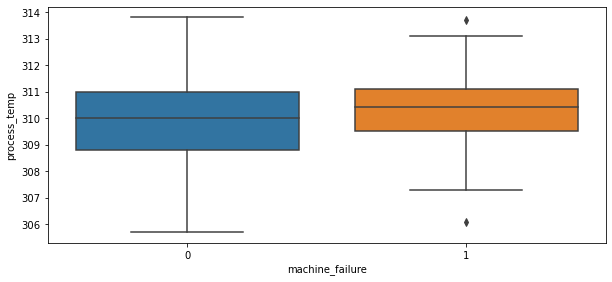

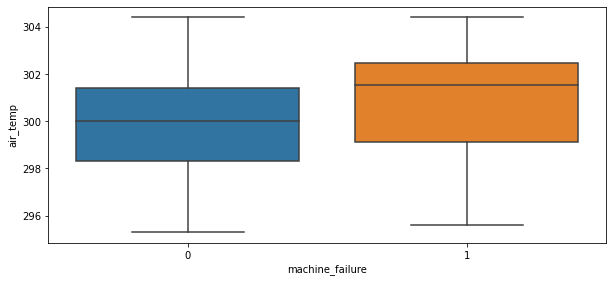

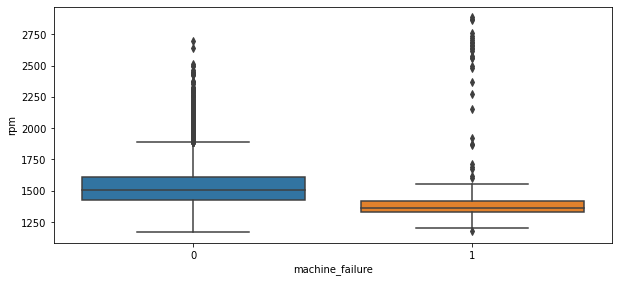

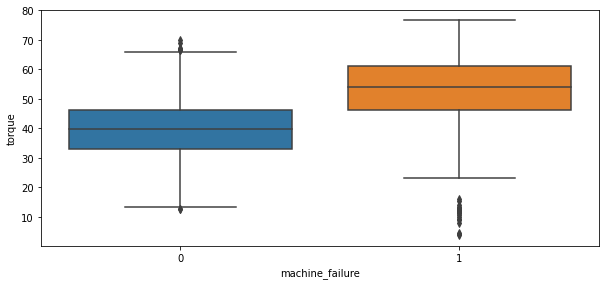

In [32]:
cols = ['process_temp', 'air_temp', 'rpm', 'torque']
fails = ['machine_failure']
m=2
for col in cols:
    for fail in fails:
        plt.figure(figsize=(10,20))
        plt.subplot(4,1, m)
        sns.boxplot(data= train, y= col, x = fail)
        plt.show()

* The outliers in RPM could lead to more confusion within the models and the correlation with overall failure is lower. For that reason I wll drop rpm from this train to see how it impacts machine failure without the collinearity

* Air temp has a higher median failure temp with no outliers. The higher median could give a benefit to the model in distinguishing between fail or no fail

In [35]:
# train_drop = train_drop.drop(columns=['rpm', 'process_temp'])

train_drop.head()

,air_temp,torque,tool_wear,machine_failure,failure_type,H,L,M
5884,301.3,43.0,137,0,No Failure,0,0,1
6928,301.1,24.5,7,0,No Failure,0,1,0
4514,302.4,36.2,115,0,No Failure,0,1,0
9532,299.2,48.7,93,0,No Failure,0,1,0
6607,301.5,39.1,48,0,No Failure,0,1,0


#
---
## Multiclassification model 

In [ ]:
# Splitting the x and y variables for the model for all three subsets
x_train = train.drop(columns = ['machine_failure', 'failure_type'])
x_validate = validate.drop(columns = ['machine_failure', 'failure_type'])
x_test = test.drop(columns = ['machine_failure', 'failure_type'])

y_train = train['machine_failure']
y_validate = validate['machine_failure']
y_test = test['machine_failure']